In [0]:
#Imports
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
import random
from random import shuffle
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from tabulate import tabulate
import copy
import os, shutil, time, imageio
import itertools
import pickle
import math
from PIL import Image
from torchvision import transforms, datasets, utils
from torch.autograd import Variable
from IPython.display import Image as im

In [0]:
# Hyper-Parameters

hparams={
    'batch_size':200,
    'test_batch_size':200,
    'validation_batch_size':200,
    'num_epochs':10,
    'learning_rate':1e-3,
    'learning_rate_small':1e-4,
    'log_interval':150,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

hparams_architecture={
    'kernel_size_l1':5,
    'kernel_size_l2':5,
    'padding':2,
    'num_filters_l1':35,
    'num_filters_l2':50,
    'stride':2,
}


random_seed= 25
np.random.seed(random_seed)
torch.manual_seed(random_seed)
shuffle_dataset = True

# **Exercise 1. Convolutional Autoencoder:** 
STEPS

1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.

In [0]:
#Normalize the data to have mean=0 and variance=1
train_set=datasets.MNIST('data',train=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]),download=True)
test_set=datasets.MNIST('data',train=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]),download=True)

#### Validation split ######
split_p=0.05
split=int(np.floor(split_p*len(train_set))) 

indices = list(range(len(train_set)))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PyTorch Subsets:
train_subset= torch.utils.data.Subset(train_set, train_indices)
valid_subset = torch.utils.data.Subset(train_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=hparams['batch_size'])
validation_loader = torch.utils.data.DataLoader(valid_subset, batch_size=hparams['batch_size'])
test_loader = torch.utils.data.DataLoader(test_set ,batch_size=hparams['test_batch_size'])

2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).

In [0]:
#Conv Block includes a Conv2D layer, a ReLU, and a Pooling layer, to simplify implementation of larger blocks
class ConvBlock(nn.Module):
  """ 
  This is a class for a simple convolution in 2D where an activation function (in this class ReLU type is used) and a Pooling (MaxPooling) are activated at its output. 
    
  Attributes: 
      num_inp_channels (int): Number of channels from the input image. 
      num_out_fmaps (int): Output as feature maps from the convolution in 2D.
      kernel_size (int): Kernel size of the filter.
      pool_size (int): Pool size for MaxPooling function.
  """
  def __init__(self, num_inp_channels, num_out_fmaps, 
               kernel_size, pool_size=2): 
    """ 
    The constructor for ConvBlock class. The Conv2D, the ReLU and MaxPooling functions are defined here.
    
    The convolution is done with the default parameters provided by nn.Torch, 
    except Padding whose value is defined in hparams_architecture.

    Parameters: 
        num_inp_channels (int): Number of channels of the input image. 
        num_out_fmaps (int): Output as feature maps computed by the convolution in 2D.
        kernel_size (int): Kernel size of the filter.
        pool_size (int): Pool size for MaxPooling function.
    """
    super().__init__()

    self.conv=nn.Conv2d(num_inp_channels,
                        num_out_fmaps,
                        kernel_size, 
                        padding=hparams_architecture['padding']
                        )
    
    self.relu=nn.ReLU()

    self.maxpool=nn.MaxPool2d(pool_size)
  
  def forward(self, x):
    """ 
    The function defines the network Conv2D-->ReLU-->MaxPooling

    Parameters: 
        x (Tensor): Input image.
      
    Returns: 
        ConvBlock: A network formed with Conv2D-->ReLU-->MaxPooling
    """
    return self.maxpool(self.relu(self.conv(x)))

###############################################################################

class Encoder(nn.Module):
  """ 
  This is a class for defining an Encoder network.
    
  Attributes: 
      bottleneck (int): number of features at the output of the encoder.
  """

  def __init__(self, bottleneck):
    """ 
    The constructor for Encoder class. The two convolution layers of an encoder, a flatten, and linear layer are defined here.
    
    For convolution layers we use ConvBlock class, and all parameters needed are given by hparams_architecture. 
    Linear layer for its input definition takes into account the image size, whose value in this case is 28x28, 
    and the number of filters from the output of convolutional layers. For the output the bottleneck size.

    Parameters: 
        bottleneck (int): number of features at the output of the encoder.
    """
    super().__init__()

    self.conv1 = ConvBlock(1, 
                           hparams_architecture['num_filters_l1'], 
                           hparams_architecture['kernel_size_l1']
                           )
    
    self.conv2 = ConvBlock(hparams_architecture['num_filters_l1'], 
                           hparams_architecture['num_filters_l2'], 
                           hparams_architecture['kernel_size_l2']
                           )
    
    self.flat=nn.Flatten()

    self.lin=nn.Linear(in_features=((int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2']),
                       out_features=bottleneck)

  def forward(self,x):
    """ 
    The function defines the network: 
    
    Conv2D-->ReLU-->MaxPooling-->Conv2D-->ReLU-->MaxPooling-->Linear

    Parameters: 
        x (Tensor): Input image.
      
    Returns: 
        Encoder: The chosen network.
    """
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.flat(x)
    y=self.lin(x)
    
    return y

#################################################################################

class Decoder(nn.Module):
  """ 
  This is a class for defining an Decoder network.
    
  Attributes: 
      bottleneck (int): number of features at the output of the encoder.
  """
  def __init__(self, bottleneck):
    """ 
    The constructor for Decoder class. Inverse process of the encoder. It's formed by Deconvolutions (ConvTranspose2D) and linear layers.
    In this class, ReLU is defined too, since we don't use ConvBlock class.
    
    All parameters are given by the hyperparameters.

    Parameters: 
        bottleneck (int): number of features at the input of the decoder.
    """
    super().__init__()
    
    self.lin=nn.Linear(in_features=bottleneck,
                      out_features=(int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2'])  

    self.deconv_l1=nn.ConvTranspose2d(in_channels=hparams_architecture['num_filters_l2'],
                        out_channels=hparams_architecture['num_filters_l1'],
                        kernel_size=hparams_architecture['kernel_size_l2'],
                        stride=hparams_architecture['stride'],
                        padding=hparams_architecture['padding'],
                        output_padding=1)

    self.deconv_l2=nn.ConvTranspose2d(in_channels=hparams_architecture['num_filters_l1'],
                        out_channels=1,
                        kernel_size=hparams_architecture['kernel_size_l1'],
                        stride=hparams_architecture['stride'],
                        padding=hparams_architecture['padding'],
                        output_padding=1)
    
    self.relu=nn.ReLU()
    self.tanh=nn.Tanh()

  def forward(self,x):
    """ 
    The function defines the network: 
    
    Linear-->ConvTrans2D-->ReLU-->ConvTrans2D-->ReLU

    Parameters: 
        x (Tensor): A label.
      
    Returns: 
        Decoder: The chosen network.
    """
    x=self.lin(x)
    x=x.view(-1, hparams_architecture['num_filters_l2'],int(28/4),int(28/4))
    y=self.tanh(self.deconv_l2(self.relu(self.deconv_l1(x))))
    return y

###############################################################################

class Autoencoder(nn.Module):
  """ 
  This is a class for defining an Autoencoder network.
    
  Attributes: 
      bottleneck (int): number of features at the output of the encoder and the input of the decoder.
  """
  def __init__(self,bottleneck):
    """ 
    The constructor for Autoencoder class. Encoder and Decoder objects are declared here.

    Parameters: 
        bottleneck (int): number of features at the output of the encoder at the input of the decoder.
    """
    super().__init__()

    self.encoder = Encoder(bottleneck)
    self.decoder = Decoder(bottleneck)

  def forward(self,x):
    """ 
    The function defines the network: 
    
    Encoder-->Decoder

    Parameters: 
        x (Tensor): Input image.
      
    Returns: 
        Autoencoder: The chosen network.
    """
    x=self.encoder(x)
    y=self.decoder(x)
    return y

3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.

In [0]:
#Epoch function definitions

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  """ 
  Function where the network is trained according to the kind of optimzer and criterion.
  Losses are from the images.
  
  Parameters: 
      train_loader (DataLoader): Training dataset whose purpose is teaching to a network.
      network (Autoencoder): The chosen network.
      optimizer (RMSprop): The type of the optimizer.
      criterion (MSELoss): Loss function that is used.
      hparams (dict): Hyperparameters for defining training parameters.
    
  Returns: 
      train_losses: List of losses. Each component is the mean of image loss by each batch.
  """
  network.train()
  device = hparams['device']
  train_losses = []
  for batch_idx, (data,target) in enumerate(train_loader):
      data = data.to(device)      
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, data, reduction='sum')
      loss.backward()
      train_losses.append(loss.item()/hparams['batch_size'])
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()/hparams['batch_size']))
  return train_losses

def val_epoch(validation_loader, network, hparams, plot_boolean):
  """ 
  Function where the network is computing a validation of the trained network.
  
  Parameters: 
      validation_loader (DataLoader): Validation dataset whose purpose is making a confirmation on how the well-trained network is.
      network (Autoencoder): The chosen trained network.
      hparams (dict): Hyperparameters for defining validation parameters.
    
  Returns: 
      validation_loss: Average loss from validation dataset in image level. 
  """
  network.eval()
  device = hparams['device']
  validation_loss = 0
  with torch.no_grad():
      for batch_idx, (data,target) in enumerate(validation_loader):
          data = data.to(device)
          output = network(data)
          validation_loss += criterion(output, data, reduction='sum').item() 
  validation_loss /= len(validation_loader.dataset)
  if plot_boolean:
    print('\n Validation set: Average loss: {:.4f} \n'.format(validation_loss))
  return validation_loss

In [0]:
#Run the training (long time)

bottleneck_array=[2,10,15,20]

network_array=[]
for i in range(0,len(bottleneck_array)):
  network_array.append(Autoencoder(bottleneck_array[i]))

tr_losses_array = []
val_losses_array = []
for pos in range(0,len(bottleneck_array)):
    tr_losses = []
    val_losses = []

    bottleneck=bottleneck_array[pos]
    network=network_array[pos]
    print('Begin training network with bottleneck size {}'.format(bottleneck) + '\n')

    network.to(hparams['device'])
    optimizer = optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
    criterion = F.mse_loss

    for epoch in range(1, hparams['num_epochs'] + 1):
      tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
      val_loss = val_epoch(validation_loader, network, hparams,True)
      val_losses.append(val_loss)

    tr_loss_flat = [item     for sublist in tr_losses     for item in sublist]
    tr_losses_array.append(tr_loss_flat)
    val_losses_array.append(val_losses)

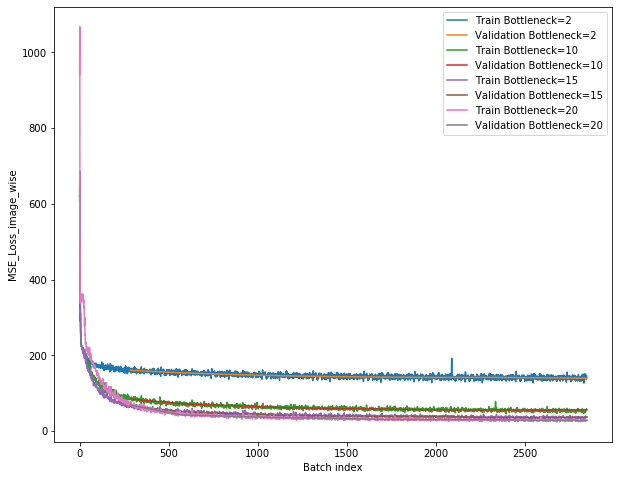

In [0]:
plt.figure(figsize=(10, 8))
for pos in range(0,len(bottleneck_array)):
    plt.xlabel('Batch index')
    plt.ylabel('MSE_Loss_image_wise')
    plt.plot(range(0, len(train_loader)*hparams['num_epochs']), tr_losses_array[pos], label='Train Bottleneck='+str(bottleneck_array[pos]))
    plt.plot(range(len(train_loader), (hparams['num_epochs']+1)*len(train_loader), len(train_loader)), val_losses_array[pos], label='Validation Bottleneck='+str(bottleneck_array[pos]))
    plt.legend()

4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.

In [0]:
def model_params(model):
  """ 
  Function that sum the number of parameters of a network.
  
  Parameters: 
      model (network): The chosen network.
    
  Returns: 
      pp: Number of parameters of a network.
  """
  pp=0
  for p in list(model.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn 
  return pp

In [0]:
#VALIDATION MSE_error

validation_error=[]
for i in range(0,len(network_array)):
  validation_error.append(val_epoch(validation_loader, network_array[i], hparams,plot_boolean=False))

#TEST MSE_error

test_error=[]
for i in range(0,len(network_array)):
  test_error.append(val_epoch(test_loader, network_array[i], hparams,plot_boolean=False))

#NUMBER OF PARAMETERS
number_param=[]
for i in range(0,len(network_array)):
  number_param.append(model_params(network_array[i]))


header=['Bootleneck Size','Validation error','Test error', 'Number of parameters']  
data=np.array([bottleneck_array,validation_error,test_error,number_param])

print(tabulate(data.transpose(),header))

  Bootleneck Size    Validation error    Test error    Number of parameters
-----------------  ------------------  ------------  ----------------------
                2            139.462       138.707                   101623
               10             56.0881       55.0728                  140831
               15             36.6327       35.7806                  165336
               20             28.2183       27.4763                  189841


5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.

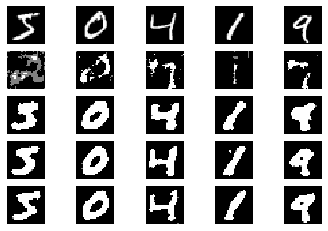

In [0]:
N=5
images=train_set.data[0:N]
image=images.view(N,1,28,28)

images_out_set=[]

dtype_t = torch.cuda.FloatTensor
for i in range(0,len(network_array)):
  images_out_set.append(network_array[i](image.cpu().type(dtype_t)).view(-1,28,28).cpu().int())

f,matrix=plt.subplots(len(bottleneck_array)+1, N)

for i in range(0,len(bottleneck_array)+1):
  for j in range(0,N):
    if i==0:
      matrix[i,j].imshow(images[j],cmap='gray')
    else:
      matrix[i,j].imshow(images_out_set[i-1][j],cmap='gray')
    matrix[i,j].axis('off')

6. Generate 5 new images by injecting random values as input to the decoder. Show them.

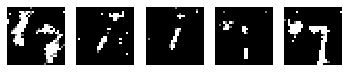

In [0]:
N=5
pos=0
device=hparams['device']
random_input=torch.randn(N,bottleneck_array[pos])*255
random_input=random_input.to(device)

images_art=network_array[pos].decoder(random_input)
images_art=images_art.view(-1,28,28)
images_art=images_art.cpu().int()

f,array=plt.subplots(1, N)

for j in range(0,N):
  array[j].imshow(images_art[j],cmap='gray')
  array[j].axis('off')

# **Exercise 2. Transfer Learning**

Steps:
1. Select a subset of 100 images and their associated labels from the MNIST training data.


In [0]:
N=100
list_images = list(range(0, N))

trainset_class = torch.utils.data.Subset(train_set, list_images)

trainloader_class = torch.utils.data.DataLoader(trainset_class, batch_size=10, shuffle=True)

print("Num of samples: ", len(trainloader_class.dataset))

Num of samples:  100


2. Select one of the previously trained autoencoders.

3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

In [0]:
num_classes = 10
hparams['num_epochs']=20

class ClassifierMNIST(nn.Module):
  """ 
  This is a class for defining a Classifier network based on an encoder and a linear layer.
    
  Attributes: 
      bottleneck (int): number of features at the output of the encoder and the input of the decoder.
      encoder (Encoder): Initialization of the used encoder.
  """
  def __init__(self, bottleneck, encoder):
    """ 
    The constructor for ClassifierMNIST class. An encoder, a projection, funcion activation ReLU and Softmax are defined here.

    Parameters: 
      bottleneck (int): number of features at the output of the encoder and the input of the decoder.
      encoder (Encoder): Initialization of the used encoder.
    """
    super().__init__()
    self.encoder = encoder
    self.lin=nn.Linear(bottleneck, num_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)


  def forward(self,x):
    """
    Function that generates the following network is:
    Encoder-->Linear-->Softmax

    Parameters:
      x (tensor): Input image.

    Returns: A label which each component will be between 0 and 1 value.
    """
    x = self.encoder(x)
    x = self.lin(x)
    y = self.softmax(x)
    return y

In [0]:
#Training function definitions

def correct_predictions(predicted_batch, label_batch):
  """ 
  Function that computes the sum the correct predicted labels in a batch.
  
  Parameters: 
    predicted_batch (Tensor): Labels are given by an image that passthrough a trained network.
    label_batch (Tensor): Labels that are the target.

  Returns: 
    acum: Number of correct predictions.
  """
  pred = predicted_batch.argmax(dim=1, keepdim=True) 
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_class_epoch(train_loader, network, optimizer, criterion, hparams):
  """ 
  Function where the network is trained according to the kind of optimzer and criterion.
  Losses are from labels.
  
  Parameters: 
      train_loader (DataLoader): Training dataset whose purpose is teaching to a network.
      network (Autoencoder): The chosen network.
      optimizer (RMSprop): The type of the optimizer.
      criterion (NLLLoss): Loss function that is used.
      hparams (dict): Hyperparameters for defining training parameters.
    
  Returns: 
      train_losses: List of losses. Each component is the mean of image loss by each batch.
  """
  network.train()
  device = hparams['device']
  train_losses = []

  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      train_losses.append(loss.item())
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return train_losses

def val_class_epoch(validation_loader, network, criterion, hparams, type_set):
  """ 
  Function where the network is computing a validation of the trained network.
  
  Parameters: 
      validation_loader (DataLoader): Validation dataset whose purpose is making a confirmation on how the well-trained network is.
      network (Autoencoder): The chosen trained network.
      criterion (NLLLoss): Loss function that is used.
      hparams (dict): Hyperparameters for defining validation parameters.
      type_set (bool): What type of printing:
        * True: Validation phase metrics.
        * False: Testing phase metrics.
    
  Returns: 
      val_loss: Average loss from validation/testing dataset.
      val_acc: Average accuracy from validation/testing dataset.
  """
  # if type_set = True --> validation phase
  # if type_set = False --> testing phase
  network.eval()
  
  device = hparams['device']
  val_loss = 0
  acc = 0
  with torch.no_grad():
      for batch_idx, (data, target) in enumerate(validation_loader):
          data, target = data.to(device), target.to(device)
          output = network(data)
          val_loss += criterion(output, target).item()        
          acc += correct_predictions(output, target)

  # Average accuracy across all correct predictions batches
  val_loss /= len(validation_loader)
  val_acc = 100. * acc / len(validation_loader.dataset)

  if type_set:
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, acc, len(validation_loader.dataset), val_acc,
        ))
  else:
    print('Testing set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, acc, len(validation_loader.dataset), val_acc,
        ))
  return val_loss, val_acc

4. Pre-training: use the weights of the autoencoders as initial values for the network weights and train a classification model on the subset of 100 samples.

5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

6. From scratch: train a model on the 100 samples without reusing the decoder weights at all.

In [0]:
pos=1
encoder_net1 = copy.deepcopy(network_array[pos].encoder)
encoder_net2 = copy.deepcopy(network_array[pos].encoder)
bottleneck=bottleneck_array[pos]
criterion_class=nn.NLLLoss()

# Pre-trained metrics
tr_losses_pt = []
val_losses_pt = []
val_accs_pt = []
test_losses_pt = []
test_accs_pt = []

# Pre-training
print("Pre-training:")
print("-------------")
network1=ClassifierMNIST(bottleneck, encoder_net1)
network1.to(hparams['device'])
optimizer1 = optim.RMSprop([
                            {'params':network1.lin.parameters()},
                            {'params':network1.encoder.parameters(), 'lr':0}],
                           lr=hparams['learning_rate'])


for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_pt.append(train_class_epoch(trainloader_class, network1, optimizer1, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network1, criterion_class, hparams, type_set=True)
  val_losses_pt.append(val_loss_class)
  val_accs_pt.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network1, criterion_class, hparams, type_set=False)
  test_losses_pt.append(test_loss_class)
  test_accs_pt.append(acc_test)
  
tr_loss_pt_flat = [item     for sublist in tr_losses_pt     for item in sublist]

In [0]:
# Fine-tuning metrics
tr_losses_ft = []
val_losses_ft = []
val_accs_ft = []
test_losses_ft = []
test_accs_ft = []

# Fine-tuning
print("Fine-tuning:")
print("------------")
network2=ClassifierMNIST(bottleneck, encoder_net2)
network2.to(hparams['device'])
optimizer2 = optim.RMSprop([
                            {'params':network2.lin.parameters()},
                            {'params':network2.encoder.parameters(), 'lr':hparams['learning_rate_small']}],
                           lr=hparams['learning_rate'])

for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_ft.append(train_class_epoch(trainloader_class, network2, optimizer2, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network2, criterion_class, hparams, type_set=True)
  val_losses_ft.append(val_loss_class)
  val_accs_ft.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network2, criterion_class, hparams, type_set=False)
  test_losses_ft.append(test_loss_class)
  test_accs_ft.append(acc_test)

tr_loss_ft_flat = [item     for sublist in tr_losses_ft     for item in sublist]

In [0]:
# From Scratch metrics
tr_losses_fs = []
val_losses_fs = []
val_accs_fs = []
test_losses_fs = []
test_accs_fs = []

# From Scratch
print("From-scratch:")
print("-------------")
network3=ClassifierMNIST(bottleneck, Encoder(bottleneck))
network3.to(hparams['device'])
optimizer3 = optim.RMSprop(network3.parameters(), lr=hparams['learning_rate'])


for epoch in range(1, hparams['num_epochs'] + 1):
  # Training phase
  tr_losses_fs.append(train_class_epoch(trainloader_class, network3, optimizer3, criterion_class, hparams))
  # Validation phase
  val_loss_class, acc_val = val_class_epoch(validation_loader, network3, criterion_class, hparams, type_set=True)
  val_losses_fs.append(val_loss_class)
  val_accs_fs.append(acc_val)
  # Testing phase
  test_loss_class, acc_test = val_class_epoch(test_loader, network3, criterion_class, hparams, type_set=False)
  test_losses_fs.append(test_loss_class)
  test_accs_fs.append(acc_test)

tr_loss_fs_flat = [item     for sublist in tr_losses_fs     for item in sublist]

Plot the loss curves (Train and Validation) for the 3 models above

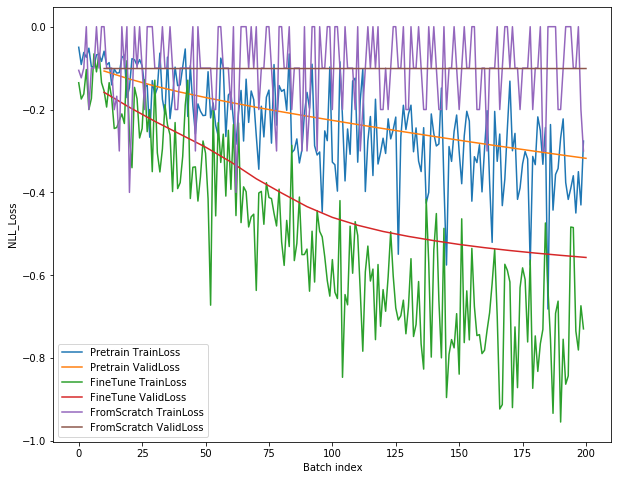

In [0]:
plt.figure(figsize=(10, 8))
plt.xlabel('Batch index')
plt.ylabel('NLL_Loss')
plt.plot(range(0, len(trainloader_class)*hparams['num_epochs']), tr_loss_pt_flat, label='Pretrain TrainLoss')
plt.plot(range(len(trainloader_class), (hparams['num_epochs']+1)*len(trainloader_class), len(trainloader_class)), val_losses_pt, label='Pretrain ValidLoss')
plt.plot(range(0, len(trainloader_class)*hparams['num_epochs']), tr_loss_ft_flat, label='FineTune TrainLoss')
plt.plot(range(len(trainloader_class), (hparams['num_epochs']+1)*len(trainloader_class), len(trainloader_class)), val_losses_ft, label='FineTune ValidLoss')
plt.plot(range(0, len(trainloader_class)*hparams['num_epochs']), tr_loss_fs_flat, label='FromScratch TrainLoss')
plt.plot(range(len(trainloader_class), (hparams['num_epochs']+1)*len(trainloader_class), len(trainloader_class)), val_losses_fs, label='FromScratch ValidLoss')
plt.legend()

7. Show the accuracy of the three models on the MNIST test set in a table.

In [0]:
models = np.array(["Pre-trained", "Fine-tuned", "From-scratch"])
test_accuracies = np.array([test_accs_pt[-1], 
                            test_accs_ft[-1], 
                            test_accs_fs[-1]])

header=['Model', 'Accuracy']
data=np.array([models,test_accuracies])

print(tabulate(data.transpose(),header))

Model           Accuracy
------------  ----------
Pre-trained        42.52
Fine-tuned         60.47
From-scratch       10.28


# **Exercise 3. Variational Autoencoder**

Steps:

1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.

2. Train the model optimizing the Evidence Lower Bound (ELBO).

3. Generate samples with the decoder and show them.

In [0]:
class Encoder_double(nn.Module):
  """ 
  This is a class for defining an Encoder network.
    
  Attributes: 
      bottleneck (int): number of features at the output of the encoder.
  """
  def __init__(self, bottleneck):
    """ 
    The constructor for Encoder class. The two convolution layers of an encoder, a flatten, and linear layer are defined here.
    
    For convolution layers we use ConvBlock class, and all needed parameters are given by hparams_architecture. 
    Linear layer for its input definition takes into account the image size, whose value in this case is 28x28, 
    and the number of filters from the output of convolutional layers. For its outputs size, is selected by double value of bottleneck parameter.

    Parameters: 
        bottleneck (int): number of features at the output of the encoder. Its double value will be the output size of the network.
    """
    super().__init__()

    self.conv1 = ConvBlock(1, 
                           hparams_architecture['num_filters_l1'], 
                           hparams_architecture['kernel_size_l1']
                           )
    
    self.conv2 = ConvBlock(hparams_architecture['num_filters_l1'], 
                           hparams_architecture['num_filters_l2'], 
                           hparams_architecture['kernel_size_l2']
                           )
    
    self.flat=nn.Flatten()

    self.lin=nn.Linear(in_features=((int(28/(hparams_architecture['stride']**2))**2)*hparams_architecture['num_filters_l2']),
                       out_features=2*bottleneck)

  def forward(self,x):
    """ 
    The function defines the network: 
    
    Conv2D-->ReLU-->MaxPooling-->Conv2D-->ReLU-->MaxPooling-->Linear

    Parameters: 
        x (Tensor): Input image.
      
    Returns: 
        Encoder_double: The chosen network.
    """
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.flat(x)
    y=self.lin(x)
    y=y.view(-1,2,bottleneck)    
    return y

class VAE(nn.Module):
  """ 
  This is a class for defining a Variational Autoencoder network. An autoencoder with a latent sampled representation between Encoder and Decoder.
  The expected weights in encoder network are for a mean and standard deviation computation.
    
  Attributes: 
      bottleneck (int): number of features at the output of the encoder and the input of the decoder.
  """
  def __init__(self,bottleneck):
    """ 
    The constructor for VAE class. Encoder and Decoder objects are declared here.

    Parameters: 
        bottleneck (int): number of features at the output of the encoder at the input of the decoder.
    """
    super().__init__()
    self.encoder = Encoder_double(bottleneck)
    self.decoder = Decoder(bottleneck)

  def forward(self,x):
    """ 
    The function defines the network: 
    
    Encoder-->latent sampled representation-->Decoder

    Parameters: 
        x (Tensor): Input image.
      
    Returns: 
        VAE: The chosen network.
    """
    values=self.encoder(x)
    means=values[:,0,:]
    log_sigmas=values[:,1,:] #To be sure that sigma is positive.
    z=torch.exp(log_sigmas)*torch.randn(means.size(dim=1),dtype=means.dtype,device=means.device)+means
    y=self.decoder(z)
    return y,log_sigmas,means

In [0]:
#Loss function.
class loss_class:
  """ 
  This is a class for defining losses computed by reconstruction and Kulback-Leibler divergence.
  This will be used for a losses criterion.
  """
  def __init__(self):
    super().__init__()

  def loss_function(data,data_out,means,log_sigmas):
    """ 
    The function computes Kulback-Leibler divergence, then losses using MSE function and finally total losses according according to calculations done before.
    
    Parameters: 
        data (Tensor): Expected image.
        data_out (Tensor): Image at the output of the network (e.g. VAE).
        means (Tensor): Means from encoder output.
        log_sigmas (Tensor): Log standard deviation from an encoder output.
      
    Returns: 
        total_loss: Losses calculated 
    """
    #Two components of the loss: reconstruction+KL divergence.
    #KL divergence can be computed using the means and variances (because we are assuming
    #that all the distributions are normal). (see appendix B of Auto-Encoding Variational Bayer; Kingma)
    DKL=-1/2*torch.sum(1+2*log_sigmas-means**2-torch.exp(2*log_sigmas)) 
    reconstruction_loss=F.mse_loss(data,data_out,reduction='sum')

    total_loss=reconstruction_loss+DKL
    return total_loss

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = []

  for batch_idx, (data,target) in enumerate(train_loader):
      data = data.to(device)      
      optimizer.zero_grad()
      output, log_sigmas, means = network(data)
      loss = criterion(data,output,means,log_sigmas)
      loss.backward()
      avg_loss.append(loss.item()/hparams['batch_size'])
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()/hparams['batch_size']))
  return avg_loss

def val_epoch(validation_loader, network, hparams, plot_boolean):
    network.eval()
    device = hparams['device']
    validation_loss = 0

    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(validation_loader):
            data = data.to(device)
            output, log_sigmas, means = network(data)
            validation_loss += criterion(data,output,means,log_sigmas).item()/hparams['batch_size'] # sum up batch loss

    # Average loss across all correct predictions batches now
    validation_loss /= len(validation_loader)
    if plot_boolean:
      print('\n Validation set: Average loss: {:.4f} \n'.format(validation_loss))
    return validation_loss

In [0]:
tr_losses = []
val_losses = []

bottleneck=10
network=VAE(bottleneck)
network.to(hparams['device'])
optimizer = optim.Adam(network.parameters(), lr=hparams['learning_rate'])
criterion = loss_class.loss_function

for epoch in range(1, hparams['num_epochs'] + 1):
    # Trainig phase
    tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
    # Validation phase
    val_loss = val_epoch(validation_loader, network, hparams,True)
    val_losses.append(val_loss)

tr_loss_flat = [item     for sublist in tr_losses     for item in sublist]
plt.figure(figsize=(10, 8))

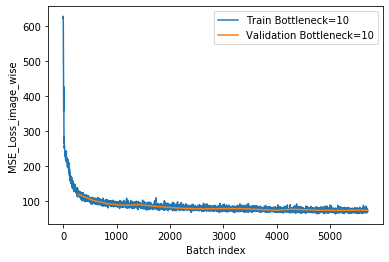

In [0]:
plt.xlabel('Batch index')
plt.ylabel('MSE_Loss_image_wise')
plt.plot(range(0, len(train_loader)*hparams['num_epochs']), tr_loss_flat, label='Train Bottleneck='+str(bottleneck))
plt.plot(range(len(train_loader), (hparams['num_epochs']+1)*len(train_loader), len(train_loader)), val_losses, label='Validation Bottleneck='+str(bottleneck))
plt.legend()

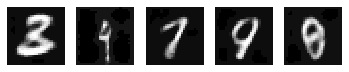

In [0]:
#3. Generate samples with the decoder and show them.

N=5 #Number of samples
device=hparams['device']
z=torch.randn(N,bottleneck).to(device)

images_art=network.decoder(z)
images_art=images_art.view(-1,28,28)*10
images_art=images_art.cpu().int()

f,array=plt.subplots(1, N)

for j in range(0,N):
  array[j].imshow(images_art[j],cmap='gray')
  array[j].axis('off')

# **Exercise 4. Conditional GAN**

Steps:

1. Implement a generator and discriminator based on deconvolutions and convolutions respectively.

2. Train the GAN on MNIST.

3. Generate samples with the generator and show them.

In [0]:
# Hyper-Parameters

hparams={
    'batch_size': 128,
    'learning_rate': 1e-4,
    'train_epoch': 20,
    'kernel_size':4,
    'padding':0,
    'stride':1,
    'input_size':100,
    'num_epochs':20
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
device = hparams['device']


In [0]:
# DATA LOADING
img_size = 32

train_set_gan=datasets.MNIST('data',train=True,transform=transforms.Compose([transforms.Resize(img_size, interpolation=0),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]),download=True)
train_loader_gan = torch.utils.data.DataLoader(train_set_gan, batch_size=hparams['batch_size'])

In [0]:
class generator(nn.Module):
  
  def __init__(self):
    super().__init__()

    self.lin=nn.Linear(hparams['input_size']+1,1024*hparams['kernel_size']**2) #We add +1 for the label.
    
    self.deconv1 =nn.Sequential(
      nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1,bias=False),
      nn.BatchNorm2d(512),
      nn.ReLU())
    
    self.deconv2 =nn.Sequential(
      nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1,bias=False),
      nn.BatchNorm2d(256),
      nn.ReLU())
    
    self.deconv3 = nn.Sequential(
      nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2,padding= 1,bias=False),
      nn.Tanh())


  def forward(self, input, label):
    x = torch.cat([input, label],dim=1)
    x = self.lin(x).view(-1,1024,hparams['kernel_size'],hparams['kernel_size'])
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)
    return x


  def weight_initialization(self, mean, std):
    for module in self._modules:
      normal_init(self._modules[module], mean, std)   

class discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    #Instead of using a convolution with the label (because it has a size of batch x 1) I add a linear
    #layer in order to map to the same dimensionality that has the image.

    self.fc_label=nn.Linear(1,32**2) #image size

    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=2, out_channels=128, kernel_size=4, stride=2, padding=1,bias=False),
      nn.LeakyReLU(0.2,inplace=True))

    self.conv2 =nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1,bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2,inplace=True))
      
    self.conv3 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1,bias=False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2,inplace=True))

    self.sigmoid = nn.Sigmoid()
    self.fc=nn.Linear(4*4*512,1) #We have to compute the Size.

  # weightn initialization
  def weight_initialization(self, mean, std):
    for module in self._modules:
      normal_init(self._modules[module], mean, std)
  
  def forward(self, input, label):
    label_out=self.fc_label(label).view(-1,1,32,32)
    x = torch.cat([input, label_out],dim=1)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,4*4*512)
    x = self.sigmoid(self.fc(x))
    return x

def normal_init(m, mean, std):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()


In [0]:
def show_result(num_epoch, image,show = False, save = False, path = 'result.png'):
  
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.imshow(image)
  label = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0.04, label, ha='center', fontsize=20)
  plt.savefig(path+str(epoch)+'.png')

  if show:
    plt.show()
  else:
    plt.close()

In [0]:
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5, save=False, path=os.getcwd()):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
      nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
      img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.detach().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    image = Image.fromarray(image_numpy.astype(imtype))

    if(save):
      #image.save(path_images+str(epoch)+'.png')
      show_result(epoch, image_numpy, show=False, save=True, path=path)

    else:
      display(image)

In [0]:
# Prepare paths
root = os.getcwd()
model = '/generated_images/'

path_images = root+model

if os.path.exists(path_images):
  shutil.rmtree(path_images)

os.mkdir(path_images)

print("Folders are initialized")

Folders are initialized


In [0]:
#TRAINING OF THE DISCRIMINATOR, used later in the training

def training_discriminator_step(data,number_label,generator,discriminator,optimizer,criterion):

  optimizer.zero_grad()

  batch=data.size()[0]
  label_real= torch.ones(batch)
  label_fake = torch.zeros(batch)
  label_real, label_fake = Variable(label_real).to(hparams['device']), Variable(label_fake).to(hparams['device']) 

  #Loss associated with the real images.
  output_discriminator=discriminator(data,number_label)
  loss_real=criterion(torch.squeeze(output_discriminator),label_real)


  dtype=torch.cuda.FloatTensor
  #Loss associated with the fake images.
  fake_images=generator(torch.randn(batch,hparams['input_size']).type(dtype),number_label)
  output_discriminator=discriminator(fake_images,number_label)
  loss_fake=criterion(torch.squeeze(output_discriminator),label_fake)

  loss=(loss_real+loss_fake)/2
  loss.backward()

  optimizer.step()

  return loss.item()


#TRAINING OF THE GENERATOR
def training_generator_step(data,number_label,generator,discriminator,optimizer,criterion):
  
  optimizer.zero_grad()

  batch=data.size()[0]
  label_real = torch.ones(batch)
  label_real= Variable(label_real).to(hparams['device'])



  dtype=torch.cuda.FloatTensor
  #We generate fake samples and test them in the discriminator.
  fake_images=generator(torch.randn(batch,hparams['input_size']).type(dtype),number_label)
  output_discriminator=discriminator(fake_images,number_label)
  loss=criterion(torch.squeeze(output_discriminator),label_real)

  loss.backward()
  optimizer.step()

  return loss.item()


# TRAINING FUNCTION
def train_epoch_net(generator,discriminator,optimizer_D, optimizer_G,criterion, train_loader_gan, path):
  D_losses = []
  G_losses = []

  for batch_ind,(data,number_label) in enumerate(train_loader_gan):

    data=data.to(hparams['device'])
    number_label=number_label.type(torch.cuda.FloatTensor).view(data.size()[0],1)

    M=torch.tensor([0,0,0,0,0,0,0,0,0,0,
                    1,1,1,1,1,1,1,1,1,1,
                    2,2,2,2,2,2,2,2,2,2,
                    3,3,3,3,3,3,3,3,3,3,
                    4,4,4,4,4,4,4,4,4,4,
                    5,5,5,5,5,5,5,5,5,5,
                    6,6,6,6,6,6,6,6,6,6,
                    7,7,7,7,7,7,7,7,7,7,
                    8,8,8,8,8,8,8,8,8,8,
                    9,9,9,9,9,9,9,9,9,9])
    
    #TRAIN DISCRIMINATOR
    D_losses.append(training_discriminator_step(data,number_label,generator,discriminator,optimizer_D,criterion))

    # TRAIN GENERATOR
    G_losses.append(training_generator_step(data,number_label,generator,discriminator,optimizer_G,criterion))


    # Show current loss
    if (batch_ind) % 10 == 0:
      print( f"batch: {batch_ind}/{len(train_loader_gan)}, G_loss: {G_losses[batch_ind]}, D_loss: {D_losses[batch_ind]}") 

    # Show fake samples
    dtype=torch.cuda.FloatTensor
    if (batch_ind) % 100 == 0:
      fake_images = generator(torch.randn(len(M),hparams['input_size']).type(dtype),M.type(torch.cuda.FloatTensor).view(-1,1))
      display_batch_images(fake_images, save=False, path=path_images)

    if(batch_ind == len(train_loader_gan)-1):
      display_batch_images(fake_images, save=True, path=path_images)
      print("Image saved at: ", path_images)

  return D_losses, G_losses



In [0]:
#TRAINING

# network
Generator = generator()
Discriminator = discriminator()

Generator.weight_initialization(mean=0.0, std=0.02)
Discriminator.weight_initialization(mean=0.0, std=0.02)

Generator.to(device)
Discriminator.to(device)

# Binary Cross Entropy loss
criterion = nn.BCELoss()

# Adam optimizer
optimizer_G = optim.Adam(Generator.parameters(), lr=hparams['learning_rate'], betas=(0.5, 0.999))
optimizer_D = optim.Adam(Discriminator.parameters(), lr=hparams['learning_rate'], betas=(0.5, 0.999))

start_time = time.time()
for epoch in range(1, hparams['num_epochs'] + 1):
  epoch_start_time = time.time()
  D_losses, G_losses=train_epoch_net(Generator,Discriminator,optimizer_D, optimizer_G,criterion, train_loader_gan, path=path_images)
  epoch_end_time = time.time()
  print("Epoch:", epoch, "Time: ", epoch_end_time - epoch_start_time)






In [0]:
# Create GIF from generated_images folder
images = []
e = 0
for e in range(hparams['num_epochs']):
    img_name = path_images + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(path_images + '/' + 'generation_animation.gif', images, fps=2)

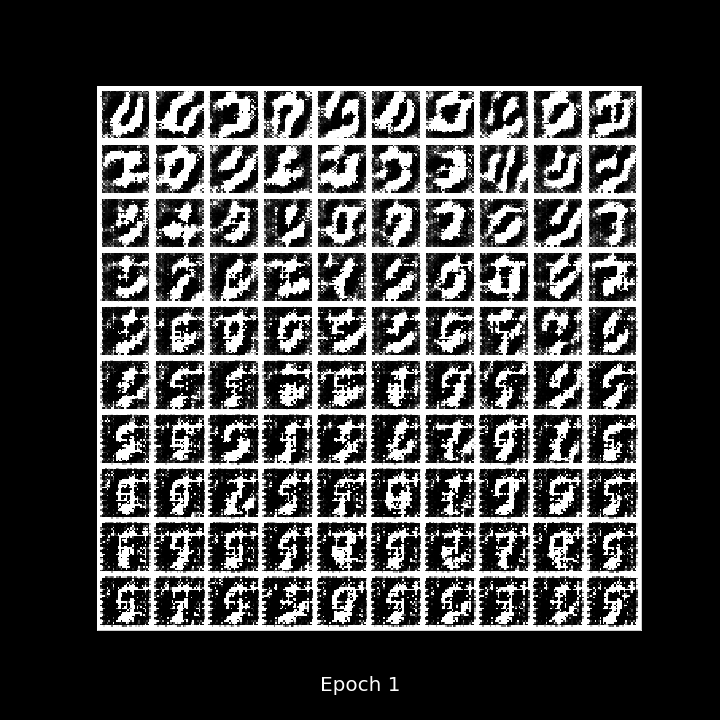

In [0]:
# Display Animation
with open(path_images + 'generation_animation.gif','rb') as file:
    display(im(file.read()))